In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [23]:
#importing the data for prices
daily_corn = pd.read_csv("corn_prices_daily.csv", dtype={"date": "string"})
daily_corn["date"] = pd.to_datetime(daily_corn["date"].str.strip(), format="%d/%m/%Y")
daily_corn = daily_corn.sort_values("date").reset_index(drop=True)
#importing data for weather
spi_and_prob = pd.read_csv("spi6_and_probabilities.csv", parse_dates=["date"])


Problem: weather available every day but price not on weekends - fallback up to 4 days.

In [24]:
# =========================
# merge the two datasets based on dates from weekly drought probabilities, then check for missing
# values - if there is a missing values fill by last available date - the furthest back you can go is
# 4 days (data on Sunday never available so last date allowed is Wed), shwo in a table how many times you need fallback
# =========================
# weekly_probs_h1 : DataFrame with Sunday 'date' + state prob columns (e.g., p_state0_h1, ...)
# daily_corn      : DataFrame with business-day 'date' + price columns (e.g., 'close', ...)
# If your dates are index instead of a column, the helper below lifts them.

def ensure_date_col(df: pd.DataFrame, date_col: str = "date") -> pd.DataFrame:
    out = df.copy()
    if date_col not in out.columns and isinstance(out.index, pd.DatetimeIndex):
        out = out.reset_index().rename(columns={"index": date_col})
    out[date_col] = pd.to_datetime(out[date_col])
    return out

# Normalize inputs
wp = ensure_date_col(spi_and_prob, "date").sort_values("date")
dc = ensure_date_col(daily_corn, "date").sort_values("date")

# (Optional) deduplicate daily prices per date, keep the last record if duplicates exist
dc = dc.drop_duplicates(subset=["date"], keep="last")

# Identify price columns (everything except 'date')
price_cols = [c for c in dc.columns if c != "date"]
if not price_cols:
    raise ValueError("No price columns found in daily_corn (expected at least one non-'date' column).")

use_dc = dc[["date"] + price_cols].copy()

# =================================
# Dataset A: exact Friday (Sun-2d)
# =================================
A = wp.copy()
A["date_for_price2"] = A["date"] - pd.Timedelta(days=2)

use_dc2 = use_dc.rename(columns={"date": "date_for_price2"})
A = (
    pd.merge(A, use_dc2, on="date_for_price2", how="left")
      .sort_values("date")
      .reset_index(drop=True)
)

# IMPORTANT: record whether Friday had price BEFORE any fallback fill
A["fri_has_price"] = A[price_cols].notna().any(axis=1)

# Save A without helper cols (keep Sunday date + probs + prices)
A_out = A.drop(columns=["date_for_price2"])
A_out.to_csv("joined_sunday_minus2_exact.csv", index=False)

# ======================================================
# Dataset B: Friday or last available (≤ Sunday - 4 days)
# ======================================================
# A, price_cols, wp, use_dc already defined above

# As-of join: last available price at/before Sunday, but only within 4 days
use_dc_asof = use_dc.copy()
use_dc_asof["price_date"] = use_dc_asof["date"]

asof_tmp = pd.merge_asof(
    wp[["date"]].sort_values("date"),
    use_dc_asof.sort_values("date"),
    on="date",
    direction="backward",
    tolerance=pd.Timedelta(days=4)   # <- cap fallback to Sunday-4
)

# Attach as-of values & fill ONLY where Friday was missing
asof_fill = asof_tmp.rename(columns={c: f"{c}__asof" for c in price_cols})
asof_fill = asof_fill.rename(columns={"price_date": "price_date__asof"})

B = pd.merge(A, asof_fill[["date", "price_date__asof"] + [f"{c}__asof" for c in price_cols]],
             on="date", how="left")

for c in price_cols:
    # If Friday had price, keep it. Else use as-of (NaN if >4 days away)
    B[c] = B[c].where(B["fri_has_price"], B[f"{c}__asof"])

# Which date did we actually use?
B["price_date_used"] = pd.NaT
B.loc[B["fri_has_price"],  "price_date_used"] = B.loc[B["fri_has_price"],  "date_for_price2"]   # Fri (Sun-2)
B.loc[~B["fri_has_price"], "price_date_used"] = B.loc[~B["fri_has_price"], "price_date__asof"]  # as-of (≤4 days)

# Fallback days (NaN if no price within ≤4 days)
B["fallback_days"] = (B["date"] - B["price_date_used"]).dt.days

# Clean & save
drop_cols = [f"{c}__asof" for c in price_cols] + ["price_date__asof", "date_for_price2", "fri_has_price"]
B_out = (B.drop(columns=drop_cols)
           .sort_values("date")
           .reset_index(drop=True))
B_out.to_csv("joined_sunday_minus2_or_last_max4d.csv", index=False)

# Quick sanity: any rows beyond 4 days? (should be none due to tolerance)
print("Rows with fallback_days > 4:", int((B_out["fallback_days"] > 4).sum()))
print("Saved:", "joined_sunday_minus2_or_last_max4d.csv")

# ==========================
# NaN summary & comparisons
# ==========================
def nan_summary(df: pd.DataFrame, cols: list[str] | None = None) -> pd.DataFrame:
    if cols is None:
        cols = df.columns.tolist()
    nn = df[cols].isna().sum()
    pp = (df[cols].isna().mean() * 100).round(2)
    return pd.DataFrame({"n_nan": nn, "pct_nan": pp}).sort_values("n_nan", ascending=False)

print("NaN summary (ALL columns) — A (exact Fri):")
print(nan_summary(A_out), end="\n\n")

print("NaN summary (ALL columns) — B (fallback):")
print(nan_summary(B_out), end="\n\n")

# ======================
# fallback analysis table
# ======================
def fallback_counts_table(df: pd.DataFrame, col: str = "fallback_days",
                          values=(2, 3, 4)) -> pd.DataFrame:
    s = pd.to_numeric(df[col], errors="coerce")  # ensure numeric
    total_non_na = s.notna().sum()
    counts = (s[s.isin(values)]
              .value_counts()
              .reindex(values, fill_value=0)
              .rename("count"))
    out = counts.to_frame()
    out["pct"] = (out["count"] / total_non_na * 100).round(2)
    return out

# If your fallback dataset is B_out:
table = fallback_counts_table(B_out, "fallback_days", values=(2, 3, 4))
print(table)

Rows with fallback_days > 4: 0
Saved: joined_sunday_minus2_or_last_max4d.csv
NaN summary (ALL columns) — A (exact Fri):
               n_nan  pct_nan
Last Price        84     4.79
spi_6              0     0.00
date               0     0.00
p_state0_h1        0     0.00
p_state1_h1        0     0.00
p_state2_h1        0     0.00
fri_has_price      0     0.00

NaN summary (ALL columns) — B (fallback):
                 n_nan  pct_nan
price_date_used      2     0.11
fallback_days        2     0.11
Last Price           2     0.11
date                 0     0.00
p_state1_h1          0     0.00
p_state0_h1          0     0.00
spi_6                0     0.00
p_state2_h1          0     0.00

               count    pct
fallback_days              
2               1668  95.31
3                 62   3.54
4                 20   1.14


In [25]:
#drop the two rows that still have NaN
data = B_out.dropna().copy()
data["ret_1"] = data["Last Price"].pct_change()   # past return t-1 -> t
data = data[1:] # to remove the first row because ret has no value
data['top_state'] = data[['p_state0_h1','p_state1_h1','p_state2_h1']].values.argmax(axis=1) #creating one class for state
data

,date,spi_6,p_state0_h1,p_state1_h1,p_state2_h1,Last Price,price_date_used,fallback_days,ret_1,top_state
1,1992-01-12,-0.676211,0.188472,0.778493,0.033035,2.43,1992-01-10,2.0,0.016736,1
2,1992-01-19,-0.408163,0.042357,0.918067,0.039576,2.48,1992-01-17,2.0,0.020576,1
3,1992-01-26,-0.149762,0.031910,0.927547,0.040544,2.55,1992-01-24,2.0,0.028226,1
4,1992-02-02,-0.012210,0.031731,0.926709,0.041559,2.57,1992-01-31,2.0,0.007843,1
5,1992-02-09,-0.154111,0.031869,0.927580,0.040551,2.57,1992-02-07,2.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...
1747,2025-06-29,-0.317970,0.047144,0.919293,0.033563,4.00,2025-06-27,2.0,-0.014778,1
1748,2025-07-06,-0.346593,0.053727,0.912975,0.033298,4.10,2025-07-03,3.0,0.025000,1
1749,2025-07-13,-0.113659,0.039652,0.926234,0.034114,3.87,2025-07-11,2.0,-0.056098,1
1750,2025-07-20,0.110532,0.035815,0.928811,0.035374,3.95,2025-07-18,2.0,0.020672,1


The states are somewhat unequal / mazbe I will need to do some sort of adapted LSTM and Logreg for this.

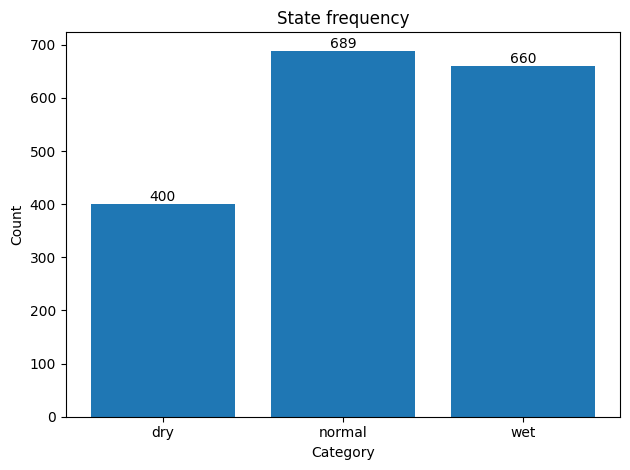

In [26]:
# Map state codes -> labels and count them in your desired order
state_to_label = {0: "dry", 1: "normal", 2: "wet"}
labels = ["dry", "normal", "wet"]

s = data["top_state"].map(state_to_label)                 # convert 0/1/2 -> labels
counts = s.value_counts().reindex(labels, fill_value=0)   # ensure fixed order

plt.figure()
plt.bar(labels, counts.values)
plt.title("State frequency")
plt.xlabel("Category")
plt.ylabel("Count")

# optional: add value labels on bars
for x, v in enumerate(counts.values):
    plt.text(x, v, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()


In [27]:
from statsmodels.tsa.stattools import adfuller #for adf test
import scipy.stats as stats #for jb test

def data_properties(data):
  label = str(data.name)
  #adf test for stationarity
  result_adf = adfuller(data)
  if result_adf[1] < 0.05:
    print(f"{label}: series appears STATIONARY at 5%.")
  else: print(f"{label}: series appears non-STATIONARY at 5%.")

  #jb test for normality
  result_jb = stats.jarque_bera(data)
  if result_jb[1] < 0.05:
    print(f"{label}: distribution deviates from normal at 5%.")
  else: print(f"{label}: distribution looks approximately normal at 5%.")

data_properties(data["Last Price"])
data_properties(data["ret_1"])
data_properties(data["p_state0_h1"])

Last Price: series appears non-STATIONARY at 5%.
Last Price: distribution deviates from normal at 5%.
ret_1: series appears STATIONARY at 5%.
ret_1: distribution deviates from normal at 5%.
p_state0_h1: series appears STATIONARY at 5%.
p_state0_h1: distribution deviates from normal at 5%.


In [28]:
# creating a classified measure of y as positive, neutral and negative return (1,0,-1)
# Define your neutral_band
neutral_band = 0.001

# Create the next return
data["next_ret"] = data["ret_1"].shift(-1)

# Create y using numpy.select (vectorized)
conditions = [
    data["next_ret"] > neutral_band,
    (data["next_ret"] >= -neutral_band) & (data["next_ret"] <= neutral_band),
    data["next_ret"] < -neutral_band
]
choices = [1, 0, -1]

data["y"] = np.select(conditions, choices, default=np.nan)
data3 = data.dropna().copy()

print(data3)


           date     spi_6  p_state0_h1  p_state1_h1  p_state2_h1  Last Price  \
1    1992-01-12 -0.676211     0.188472     0.778493     0.033035        2.43   
2    1992-01-19 -0.408163     0.042357     0.918067     0.039576        2.48   
3    1992-01-26 -0.149762     0.031910     0.927547     0.040544        2.55   
4    1992-02-02 -0.012210     0.031731     0.926709     0.041559        2.57   
5    1992-02-09 -0.154111     0.031869     0.927580     0.040551        2.57   
...         ...       ...          ...          ...          ...         ...   
1746 2025-06-22 -0.042363     0.037012     0.928556     0.034432        4.06   
1747 2025-06-29 -0.317970     0.047144     0.919293     0.033563        4.00   
1748 2025-07-06 -0.346593     0.053727     0.912975     0.033298        4.10   
1749 2025-07-13 -0.113659     0.039652     0.926234     0.034114        3.87   
1750 2025-07-20  0.110532     0.035815     0.928811     0.035374        3.95   

     price_date_used  fallback_days    

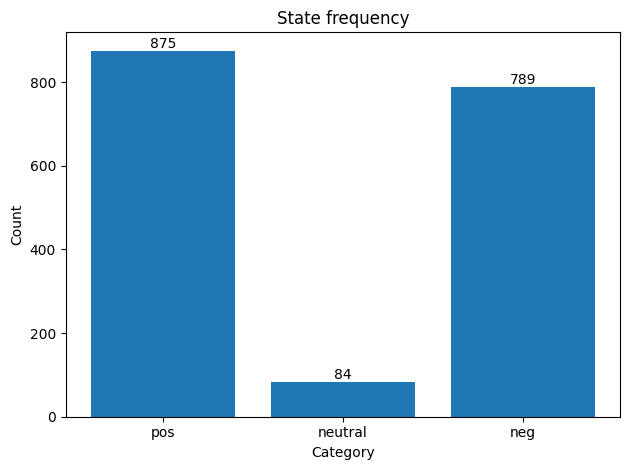

In [29]:
import matplotlib.pyplot as plt
# Map state codes -> labels and count them in your desired order
def dist_graph(data, state_to_label, labels):
  s = data.map(state_to_label)                 # convert 0/1/2 -> labels
  counts = s.value_counts().reindex(labels, fill_value=0)   # ensure fixed order

  plt.figure()
  plt.bar(labels, counts.values)
  plt.title("State frequency")
  plt.xlabel("Category")
  plt.ylabel("Count")

  #: add value labels on bars
  for x, v in enumerate(counts.values):
      plt.text(x, v, str(v), ha="center", va="bottom")
  plt.tight_layout()
  plt.show()

state_to_label_3 = {1: "pos", 0: "neutral", -1: "neg"}
labels_3 = ["pos", "neutral", "neg"]
dist_graph(data3["y"], state_to_label_3, labels_3)


In [30]:
# creating a classified measure of y as positive, neutral and negative return (1,0,-1)
# Define your neutral_band
natural_band = 0.001
data["next_ret"] = pd.to_numeric(data["ret_1"].shift(-1), errors="coerce")  # last row NaN by design
data["y"] = (data["next_ret"] > neutral_band).astype("int8")  # 1=rising, 0=otherwise
data2 = data.dropna().copy()

When we have two classes we include the zero retrun weeks in the neg retrun (I guess in real terms it has neg retrun when you deduct the risk free rate).

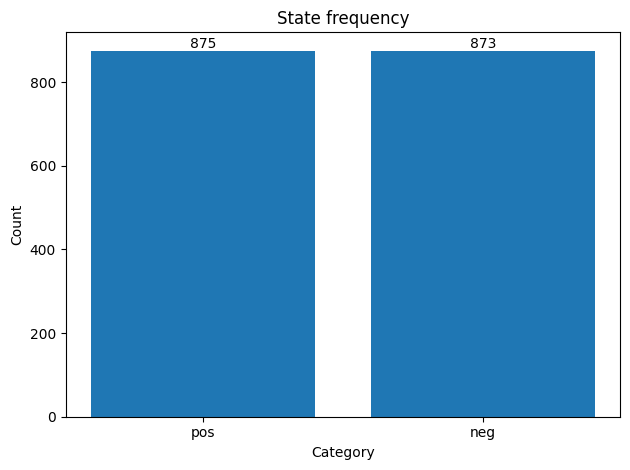

In [31]:
state_to_label_2 = {1: "pos", 0: "neg"}
labels_2 = ["pos",  "neg"]
dist_graph(data2["y"], state_to_label_2, labels_2)

In [32]:
# (Optional) Save to CSV so you have the merged view
data.to_csv("data.csv", index=False)
print("Saved merged file: data.csv")
print(data)

Saved merged file: data.csv
           date     spi_6  p_state0_h1  p_state1_h1  p_state2_h1  Last Price  \
1    1992-01-12 -0.676211     0.188472     0.778493     0.033035        2.43   
2    1992-01-19 -0.408163     0.042357     0.918067     0.039576        2.48   
3    1992-01-26 -0.149762     0.031910     0.927547     0.040544        2.55   
4    1992-02-02 -0.012210     0.031731     0.926709     0.041559        2.57   
5    1992-02-09 -0.154111     0.031869     0.927580     0.040551        2.57   
...         ...       ...          ...          ...          ...         ...   
1747 2025-06-29 -0.317970     0.047144     0.919293     0.033563        4.00   
1748 2025-07-06 -0.346593     0.053727     0.912975     0.033298        4.10   
1749 2025-07-13 -0.113659     0.039652     0.926234     0.034114        3.87   
1750 2025-07-20  0.110532     0.035815     0.928811     0.035374        3.95   
1751 2025-07-27  0.294891     0.035153     0.926273     0.038575        3.87   

     price_